In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os, pickle
import sys
sys.path.append("../")

from general.utils import load_json
from general.evaluation import get_best_model
%load_ext autoreload
%autoreload 2
%matplotlib inline

# BPF

In [2]:
dataset = 'adult'
dataset = 'lawschool'

basedir = '/data/natalia/models/'+dataset+'/BPF/'
model_name_prefix = 'BPF_512_adam5e6_'

seed = 42
loss = 'CE'

rho_dic={'01':1e-1}
rho_dic = {'01':1e-1, '02': 2e-1, '03': 3e-1,'035':0.35, '04': 4e-1, '045':0.45,'05': 5e-1,
           '06':6e-1 ,'07':7e-1,'08':8e-1, '09':9e-1 , '1':1}

rho_dic = {'01':1e-1, '02': 2e-1, '03': 3e-1,'035':0.35, '04': 4e-1, '045':0.45,'05': 5e-1,
           '06':6e-1 ,'07':7e-1,'08':8e-1, '09':9e-1 , '1':1,'015':0.15, '025':0.25, '055':0.55, 
           '065':0.65, '075':0.75, '085':0.85, '095':0.95}

epsilon_dic={'1e2':1e-2}
# epsilon_dic={'1e2':1e-2,'1e3':1e-3,'1e4':1e-4}
split_list = [1]
# split_list = [1,2,3,4,5]
nofiles_list = []

pd_summary = None
for rho_str in rho_dic.keys():
    for epsilon_str in epsilon_dic.keys():
        for split in split_list:
            model_name = model_name_prefix + loss + '_seed' + str(seed) + '_split' + \
                                     str(split) + 'rho' + rho_str + '_epsilon' + epsilon_str
            if os.path.exists(basedir+model_name+'/pd_summary_results.csv'):
                pd_summary_ix = pd.read_csv(basedir+model_name+'/pd_summary_results.csv')
                if pd_summary is None:
                    pd_summary = pd_summary_ix.copy()
                else:
                    pd_summary = pd.concat([pd_summary,pd_summary_ix],axis = 0)
                print(' load: ',model_name)
            else:
                nofiles_list.append(model_name)

if len(nofiles_list)>0:
    print('### ')
    print('Not found files : !!!!!!! ')
    for file in nofiles_list:
        print(file)

 load:  BPF_512_adam5e6_CE_seed42_split1rho01_epsilon1e2
 load:  BPF_512_adam5e6_CE_seed42_split1rho02_epsilon1e2
 load:  BPF_512_adam5e6_CE_seed42_split1rho03_epsilon1e2
 load:  BPF_512_adam5e6_CE_seed42_split1rho035_epsilon1e2
 load:  BPF_512_adam5e6_CE_seed42_split1rho04_epsilon1e2
 load:  BPF_512_adam5e6_CE_seed42_split1rho045_epsilon1e2
 load:  BPF_512_adam5e6_CE_seed42_split1rho05_epsilon1e2
 load:  BPF_512_adam5e6_CE_seed42_split1rho06_epsilon1e2
 load:  BPF_512_adam5e6_CE_seed42_split1rho07_epsilon1e2
 load:  BPF_512_adam5e6_CE_seed42_split1rho08_epsilon1e2
 load:  BPF_512_adam5e6_CE_seed42_split1rho09_epsilon1e2
 load:  BPF_512_adam5e6_CE_seed42_split1rho1_epsilon1e2
### 
Not found files : !!!!!!! 
BPF_512_adam5e6_CE_seed42_split1rho015_epsilon1e2
BPF_512_adam5e6_CE_seed42_split1rho025_epsilon1e2
BPF_512_adam5e6_CE_seed42_split1rho055_epsilon1e2
BPF_512_adam5e6_CE_seed42_split1rho065_epsilon1e2
BPF_512_adam5e6_CE_seed42_split1rho075_epsilon1e2
BPF_512_adam5e6_CE_seed42_split1r

### obtain best model parameter (rho_model = group size) per group size

In [3]:
pd_out = get_best_model(pd_summary, model_tag='rho_model', dataset_choice=['train', 'val'], precision=3)
pd_out['model'] = 'BPF'

In [4]:
#baseline is partition size (rho_model) = 1 
pd_baseline = get_best_model(pd_summary.loc[pd_summary['rho_model'] == 1], model_tag='rho_model',
                                            dataset_choice=['train', 'val'], precision=3) 
pd_baseline['model'] = 'Baseline'
pd_out = pd.concat([pd_out,pd_baseline])
# pd_out.drop(columns = ['rho_model','epsilon_model'])

# DRO

In [5]:
basedir = '/data/natalia/models/'+dataset+'/DRO/'

model_name_prefix = 'DRO_512_adam5e6_'

seed = 42
loss = 'CE'

eta_dic={'1':1, '05':0.5,'0':0}
eta_dic={'0':0, '05':0.5, '06':0.6,  '07':0.7, '08':0.8, '09':0.9, '1':1}
eta_dic={'0':0, '1':1, '01':0.1, '02':0.2, '03':0.3, '04':0.4,'05':0.5,
         '06':0.6,  '07':0.7, '08':0.8, '09':0.9,'015':0.15, '025':0.25, '035':0.35, '045':0.45,
         '055':0.55, '065':0.65,  '075':0.75, '085':0.85, '095':0.95} #eta = eta_coeff * max(eta) (e.g.: eta_coeff * np.log(2) if CE)

eta_dic={'0':0, '1':1, '01':0.1, '02':0.2, '03':0.3, '04':0.4,'05':0.5,
         '06':0.6,  '07':0.7, '08':0.8, '09':0.9,
         '012':1.2e-1,'014':1.4e-1,'016':1.6e-1,'018':1.8e-1} #eta = eta_coeff * max(eta) (e.g.: eta_coeff * np.log(2) if CE)


# eta_dic={'1':1} 

split_list = [1,2,3,4,5]
split_list = [1]
nofiles_list = []

pd_summary = None
for eta_str in eta_dic.keys():
    for split in split_list:
        model_name = model_name_prefix + loss + '_seed' + str(seed) + '_split' + \
                                 str(split) + '_eta' + eta_str

        if os.path.exists(basedir+model_name+'/pd_summary_results.csv'):
            pd_summary_ix = pd.read_csv(basedir+model_name+'/pd_summary_results.csv')
            if pd_summary is None:
                pd_summary = pd_summary_ix.copy()
            else:
                pd_summary = pd.concat([pd_summary,pd_summary_ix],axis = 0)

            print(' load: ',model_name)

        else:
            nofiles_list.append(model_name)

if len(nofiles_list)>0:
    print('### ')
    print('Not found files : !!!!!!! ')
    for file in nofiles_list:
        print(file)

 load:  DRO_512_adam5e6_CE_seed42_split1_eta0
 load:  DRO_512_adam5e6_CE_seed42_split1_eta1
 load:  DRO_512_adam5e6_CE_seed42_split1_eta01
 load:  DRO_512_adam5e6_CE_seed42_split1_eta02
 load:  DRO_512_adam5e6_CE_seed42_split1_eta03
 load:  DRO_512_adam5e6_CE_seed42_split1_eta04
 load:  DRO_512_adam5e6_CE_seed42_split1_eta05
 load:  DRO_512_adam5e6_CE_seed42_split1_eta06
 load:  DRO_512_adam5e6_CE_seed42_split1_eta07
 load:  DRO_512_adam5e6_CE_seed42_split1_eta08
 load:  DRO_512_adam5e6_CE_seed42_split1_eta09
### 
Not found files : !!!!!!! 
DRO_512_adam5e6_CE_seed42_split1_eta012
DRO_512_adam5e6_CE_seed42_split1_eta014
DRO_512_adam5e6_CE_seed42_split1_eta016
DRO_512_adam5e6_CE_seed42_split1_eta018


### obtain best model parameter (eta = loss threshold) group size

In [6]:
pd_DRO = get_best_model(pd_summary, model_tag='eta', dataset_choice=['train', 'val'], precision=3)
pd_DRO['model'] = 'DRO'
# pd_DRO.drop(columns = ['eta'])
pd_out = pd.concat([pd_out,pd_DRO])


## Plot all together

ce


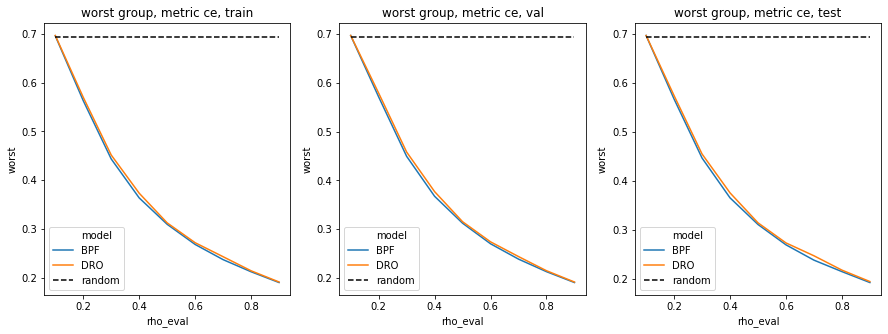

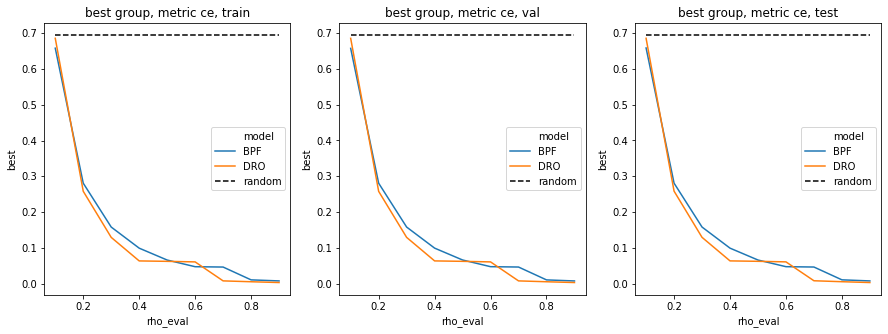



softerr


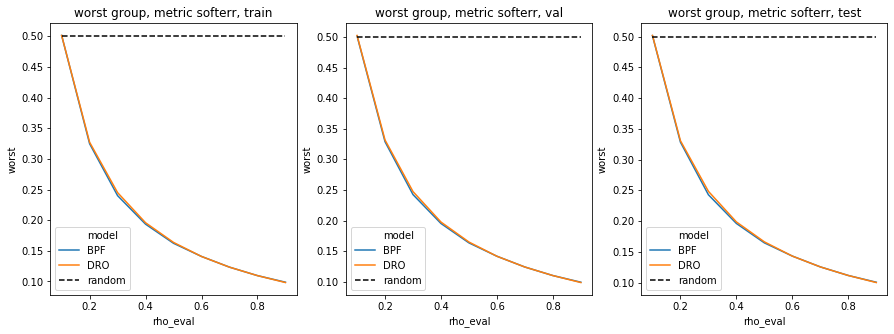

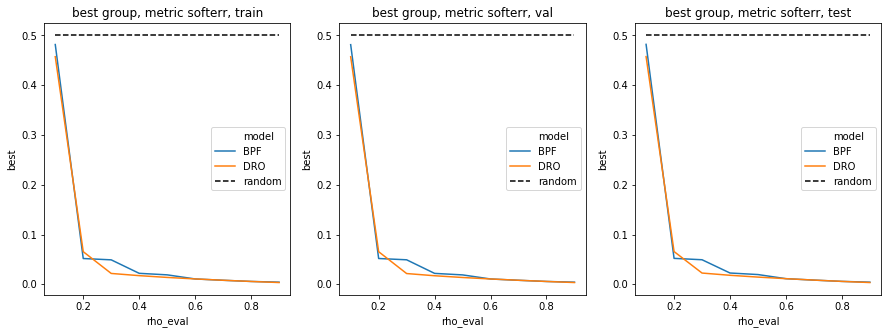

In [11]:
for metric in ['ce','softerr']:
    print(metric)
    for group in ['worst','best']:
    
        if (metric == 'softerr') | (metric == 'err'):
            value_random = 0.5
        else:
            value_random = np.log(2)
        plt.figure(figsize=(15,5))
        ix = 0
        for dataset in ['train','val','test']:
            pd_aux = pd_out.loc[(pd_out.metric == metric) & (pd_out.dataset == dataset) & (pd_out.model != 'Baseline')]

            ix += 1
            plt.subplot(1,3,ix)
            plt.title(group + ' group, metric '+metric + ', '+dataset)
            sns.lineplot(data = pd_aux, x = 'rho_eval',y=group,hue='model')
            plt.plot([pd_aux.rho_eval.min(),pd_aux.rho_eval.max()],
                     [value_random,value_random],'k--',label = 'random')
            plt.legend()
#             plt.yscale('log')
        plt.show()
    print()
    print()
    

In [108]:
# from general.utils import mkdir
# mkdir('/data/natalia/models/adult/')

In [10]:
pd_out

,dataset,metric,rho_eval,worst,best,avg,split,epsilon_model,rho_model,model,eta,eta_coeff
0,train,ce,0.1,0.695902,0.657578,0.661411,1,0.01,0.1,BPF,NaN,NaN
36,val,ce,0.1,0.696246,0.657087,0.660998,1,0.01,0.1,BPF,NaN,NaN
72,test,ce,0.1,0.696631,0.658243,0.662077,1,0.01,0.1,BPF,NaN,NaN
1,train,ce,0.2,0.563064,0.280888,0.337323,1,0.01,0.2,BPF,NaN,NaN
37,val,ce,0.2,0.570763,0.280760,0.338739,1,0.01,0.2,BPF,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
70,val,softerr,0.8,0.110241,0.005688,0.089319,1,NaN,NaN,DRO,0.0,0.0
106,test,softerr,0.8,0.111464,0.005943,0.090360,1,NaN,NaN,DRO,0.0,0.0
35,train,softerr,0.9,0.098294,0.003657,0.088830,1,NaN,NaN,DRO,0.0,0.0
71,val,softerr,0.9,0.098861,0.003498,0.089319,1,NaN,NaN,DRO,0.0,0.0
